In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.tensorboard.writer import SummaryWriter

from sklearn.model_selection import train_test_split

from common import data
from common.training import training_loop, get_predictions

from algos.supervised import SupervisedEngine

from common.models import resnet, deeplab
from common import metrics
from common.models.modutils import load_model


# Hyperparameters

In [3]:
log_dir = "./final/baseline"

horizon = 1024
stride = 512

batch_size = 16

num_epochs = 10

learning_rate = 1e-3

weight_decay = 1e-2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


# Datasets

In [4]:
paths = data.get_dataset_paths("../data")
train, test = train_test_split(paths, test_size=0.1, random_state=42)


In [5]:
m_data_train = data.Marconi100Dataset(train, scaling=data.Scaling.STANDARD)
m_data_test = data.Marconi100Dataset(test, scaling=data.Scaling.STANDARD)


Loading: 100%|██████████| 25/25 [00:12<00:00,  2.00it/s]


In [6]:
train_loader = DataLoader(
    data.UnfoldedDataset(m_data_train, horizon=horizon, stride=stride),
    batch_size,
    shuffle=True,
)
test_loader = DataLoader(
    data.UnfoldedDataset(m_data_test, horizon=horizon, stride=stride),
    batch_size,
    shuffle=False,
)


# Model

In [7]:
model = deeplab.DeepLabNet(
    resnet.ResNetFeatures(
        resnet.Bottleneck,
        resnet.RESNET50_LAYERS,
        num_features=data.NUM_FEATURES,
        return_layers=[resnet.LAYER_1, resnet.LAYER_4],
        replace_stride_with_dilation=[False, True, True],
    ),
    backbone_channels=[256, 2048],
    out_feats=1,
)

optim = AdamW(model.head.parameters(), lr=learning_rate, weight_decay=weight_decay)
lr_sched = CosineAnnealingLR(optim, num_epochs)
engine_supervised = SupervisedEngine(
    model, device, optimizer=optim, lr_scheduler=lr_sched
)


# Training

In [8]:
with SummaryWriter(log_dir + "/logs") as writer:
    training_loop(
        engine=engine_supervised,
        num_epochs=num_epochs,
        train_dataloader=train_loader,
        test_dataloader=test_loader,
        writer=writer,
        save_path=log_dir + "/models",
    )


Epoch 0 - train_loss = 0.160 - test_loss = 0.150 - test_cost=104.587 - test_threshold=-1.388 - lr = 1.00e-03


Epoch 1 - train_loss = 0.083 - test_loss = 0.155 - test_cost=109.458 - test_threshold=-1.591 - lr = 9.76e-04


Epoch 2 - train_loss = 0.127 - test_loss = 0.144 - test_cost=92.674 - test_threshold=-1.078 - lr = 9.05e-04


Epoch 3 - train_loss = 0.141 - test_loss = 0.148 - test_cost=91.983 - test_threshold=-1.715 - lr = 7.94e-04


Epoch 4 - train_loss = 0.096 - test_loss = 0.144 - test_cost=78.752 - test_threshold=-1.821 - lr = 6.55e-04


Epoch 5 - train_loss = 0.105 - test_loss = 0.141 - test_cost=83.256 - test_threshold=-1.002 - lr = 5.00e-04


Epoch 6 - train_loss = 0.090 - test_loss = 0.148 - test_cost=79.067 - test_threshold=-1.598 - lr = 3.45e-04


Epoch 7 - train_loss = 0.098 - test_loss = 0.142 - test_cost=77.404 - test_threshold=-1.438 - lr = 2.06e-04


Epoch 8 - train_loss = 0.081 - test_loss = 0.145 - test_cost=72.713 - test_threshold=-1.528 - lr = 9.55e-05


Epoch 9 - train_loss = 0.148 - test_loss = 0.140 - test_cost=71.240 - test_threshold=-1.463 - lr = 2.45e-05


# Evaluating

In [10]:
load_model(model, log_dir + "/models/model_9.pth", device);

In [11]:
# Cost model
cmodel = metrics.default_cmodel()


In [12]:
scores, labels = get_predictions(engine_supervised.predict, test_loader)


100%|██████████| 41/41 [00:10<00:00,  3.99it/s]


In [22]:
cmodel.fit(scores, labels).optimize()


(-2.2885799479484117, 110.04637)

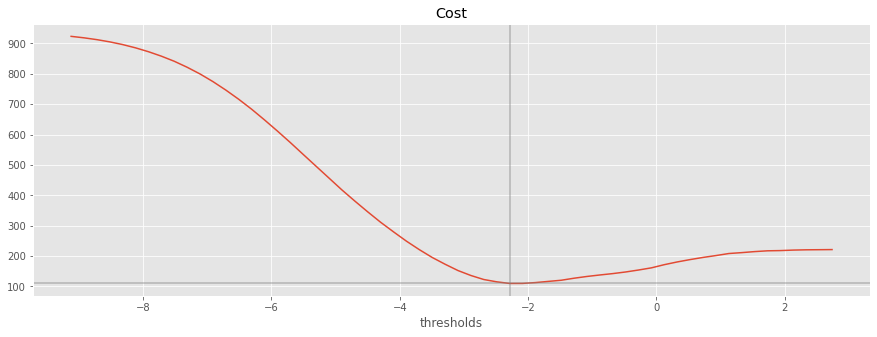

In [23]:
metrics.plot_cost(cmodel)


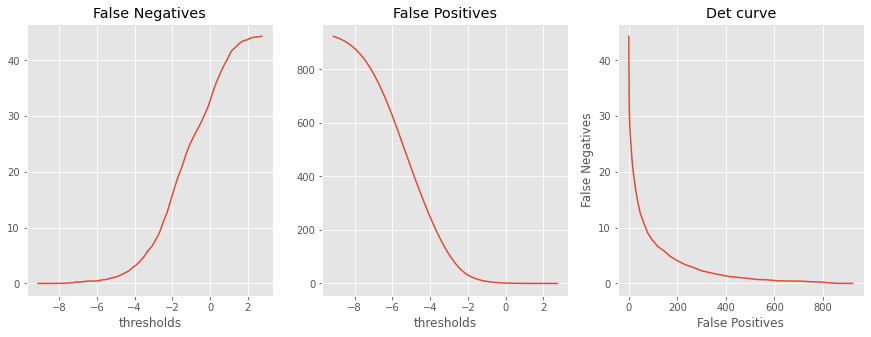

In [24]:
metrics.plot_errors_curve(
    cmodel.false_positives, cmodel.false_negatives, cmodel.thresholds, figsize=(15, 5)
)


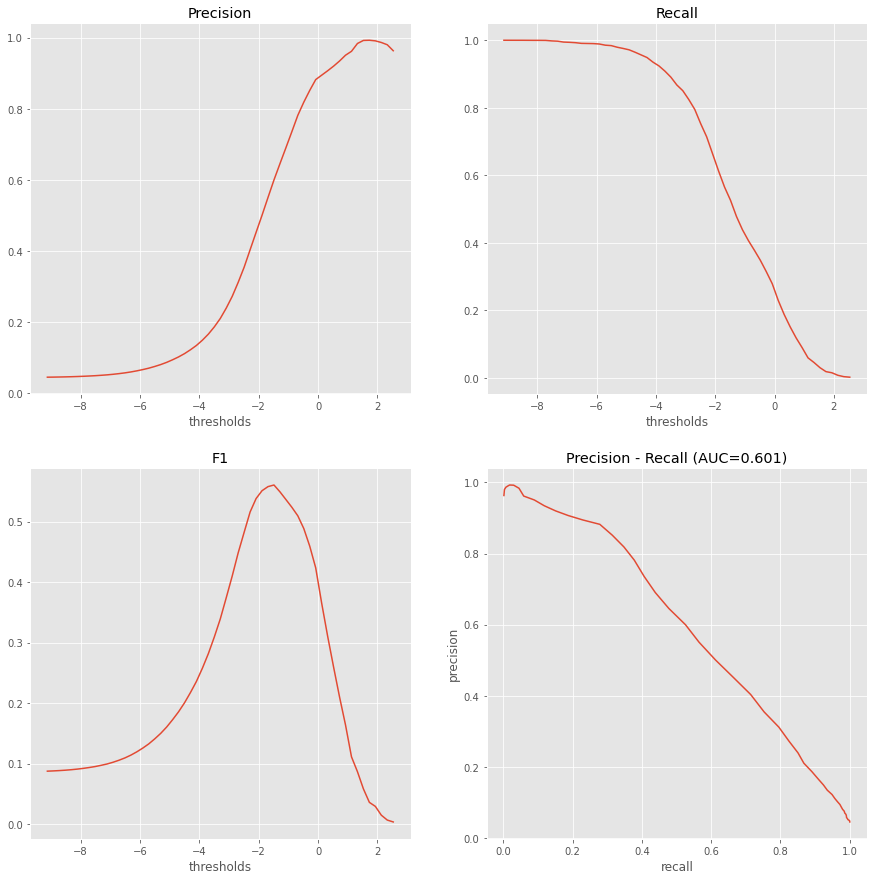

In [25]:
pr, rec, f1 = metrics.precision_recall_f1(
    cmodel.false_positives, cmodel.false_negatives
)
metrics.plot_precision_recall_f1_curve(pr, rec, f1, cmodel.thresholds)
